In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])
import torchmetrics

from tqdm.auto import tqdm
from typing import Tuple, Set, List, Union, Dict

import io
from PIL import Image
import IPython.display as disp

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path


Model selected: dfs_training/AAPL_0.1819.pth 

{'ATT_DROPOUT': 0.1,
 'ATT_HEADS': 16,
 'CLIPNORM': 1.0,
 'CLS_LOSS_WEIGHT': 1,
 'DROPOUT_LONG': 0.1,
 'DROPOUT_SHORT': 0.1,
 'EARLY_STOP_PATIENCE': 15,
 'ETA_MIN': 1e-05,
 'HUBER_BETA': 0.5,
 'INITIAL_LR': 0.001,
 'LONG_UNITS': 128,
 'LR_EPOCHS_WARMUP': 5,
 'MAX_EPOCHS': 90,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 128,
 'TRAIN_BATCH': 16,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 90,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 1e-05}


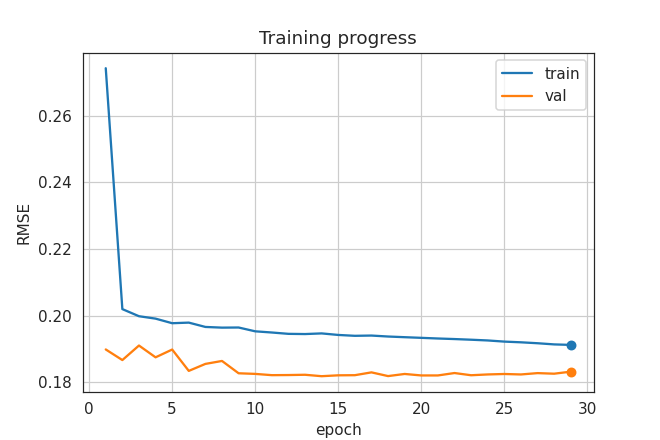

DualMemoryLSTM(
  (conv): Conv1d(15, 15, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(15, 64, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (do_short): Dropout(p=0.1, inplace=False)
  (ln_short): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.1, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
)

In [3]:
model_path = min(
    save_path.glob(f"{ticker}_*.pth"),
    key=lambda p: float(p.stem.split("_")[-1])
)
print('Model selected:', model_path,'\n')

# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

# 4) show parameters, training plot, and model
saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

png_bytes = ckpt.get("train_plot_png")
img = Image.open(io.BytesIO(png_bytes))
disp.display(img)

model_best


In [4]:
df_feat = pd.read_csv(params.feat_csv, index_col=0, parse_dates=True)
df_feat

,open,high,low,close,volume,atr_14,ma_5,ma_20,ma_diff,macd_12_26,...,bb_width_20,stoch_k_14,stoch_d_3,in_trading,hour,day_of_week,month,bid,ask,signal
2004-01-02 13:09:00,-0.193147,-0.317313,-0.028125,-0.193762,-0.319224,-1.435516,-0.185561,-0.282361,0.123688,0.202706,...,-0.929333,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763664,0.764807,0.005593
2004-01-02 13:10:00,-0.201085,-0.324262,-0.037500,-0.201725,-0.283773,-1.432540,-0.192087,-0.284115,0.112444,0.193448,...,-0.921566,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763647,0.764790,0.006095
2004-01-02 13:11:00,-0.209022,-0.331210,-0.046875,-0.209688,-0.248322,-1.429563,-0.200245,-0.286307,0.098388,0.183174,...,-0.913246,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763631,0.764773,0.006642
2004-01-02 13:12:00,-0.216960,-0.338159,-0.056250,-0.217651,-0.212872,-1.426587,-0.208402,-0.288939,0.085270,0.172220,...,-0.904541,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763614,0.764757,0.007239
2004-01-02 13:13:00,-0.224897,-0.345107,-0.065625,-0.225614,-0.177421,-1.423611,-0.216560,-0.292008,0.073088,0.160859,...,-0.895592,-1.481580,-1.561625,0,0.493,-0.976,0.351,0.763597,0.764740,0.007889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.475806,0.704918,0.500000,0.705997,5.467381,2.024482,0.367023,-0.130453,2.191746,1.957857,...,0.122381,0.619888,0.342752,1,-0.939,0.039,0.146,196.667400,196.962600,0.000000
2025-06-18 20:57:00,0.685484,0.836066,0.387097,0.478780,6.628840,2.207440,0.460866,-0.093452,2.466615,1.999189,...,0.187641,0.223810,0.415204,1,-0.939,0.039,0.146,196.527500,196.822500,0.000000
2025-06-18 20:58:00,0.467742,0.508197,0.500000,0.470665,7.630343,2.216153,0.497086,-0.060109,2.478653,2.004989,...,0.241322,0.209943,0.370103,1,-0.939,0.039,0.146,196.522500,196.817500,0.000000
2025-06-18 20:59:00,0.475806,0.524590,-0.129032,-0.227217,31.658646,2.487280,0.408182,-0.062549,2.057321,1.614144,...,0.245429,-0.982637,-0.192907,1,-0.939,0.039,0.146,196.092800,196.387200,0.043551


In [5]:
print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df            = df_feat,
    look_back     = params.look_back_tick,
    features_cols = params.features_cols_tick,
    label_col     = params.label_col,
    sess_start    = False # predictions from sess_start_pred
)

print('executing <chronological_split>...')
(
    (X_tr,  y_tr,  idxs_tr),
    (X_val, y_val, idxs_val),
    (X_te,  y_te,  raw_close_te, raw_bid_te, raw_ask_te, idxs_te),
    samples_per_day,
    day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y,
    raw_close, raw_bid, raw_ask,
    df=df_feat,
    look_back    = params.look_back_tick,
    train_prop   = params.train_prop,
    val_prop     = params.val_prop,
    train_batch  = params.hparams['TRAIN_BATCH'],
    sess_start   = False # predictions from sess_start_pred
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split
    X_tr,  y_tr,  day_id_tr,  idxs_tr,
    # val split
    X_val, y_val, day_id_val, idxs_val,
    # test split
    X_te,  y_te,  day_id_te,  idxs_te,

    # now keyword‐only args
    df            = df_feat,
    raw_close_te  = raw_close_te,
    raw_bid_te    = raw_bid_te,
    raw_ask_te    = raw_ask_te,
    train_batch   = params.hparams['TRAIN_BATCH'],
    num_workers   = params.hparams['NUM_WORKERS'],
    prefetch_factor = params.hparams['TRAIN_PREFETCH_FACTOR']
)

print('dataloaders generated!')

executing <build_lstm_tensors>...


Counting valid windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

executing <chronological_split>...
executing <split_to_day_datasets>...
dataloaders generated!


In [6]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.28600
Test zero‐forecast baseline RMSE = 0.27331


std val: 0.21428323
std test: 0.20394681


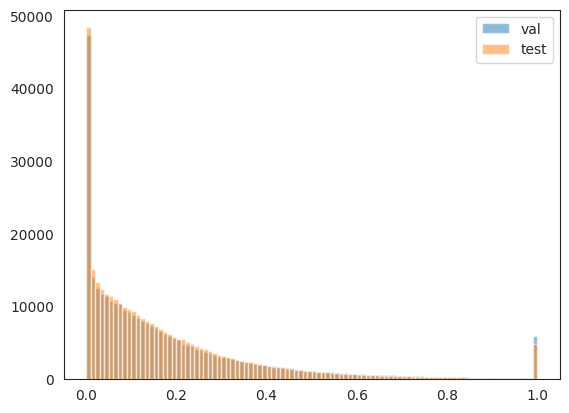

In [7]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [8]:
def evaluate_model_on_loader(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str
) -> Tuple[Dict[str, float], Dict[str, np.ndarray]]:
    """
    Run inference on `loader`, accumulate regression & classification metrics,
    and return:
      - metrics: dict of rmse, mae, r2, acc, precision, recall, f1, auroc
      - preds:   dict of flat 'reg', 'cls_prob', 'cls', and integer 'idxs'
    """
    model.to(device).eval()
    model.h_short = model.h_long = None
    prev_day_id = None

    # instantiate & reset metrics
    rmse  = torchmetrics.MeanSquaredError(squared=False).to(device); rmse.reset()
    mae   = torchmetrics.MeanAbsoluteError().to(device);         mae.reset()
    r2    = torchmetrics.R2Score().to(device);                  r2.reset()
    acc   = torchmetrics.Accuracy(task="binary", threshold=0.5).to(device); acc.reset()
    prec  = torchmetrics.Precision(task="binary", threshold=0.5).to(device); prec.reset()
    recall= torchmetrics.Recall(task="binary", threshold=0.5).to(device);    recall.reset()
    f1    = torchmetrics.F1Score(task="binary", threshold=0.5).to(device);   f1.reset()
    auroc = torchmetrics.AUROC(task="binary").to(device);                    auroc.reset()

    all_reg, all_prob, all_pred, all_idx = [], [], [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            xb, yb_reg, yb_cls, wd = batch[:4]
            idx_batch              = batch[-1]

            # move to device
            xb, yb_reg, yb_cls = [t.to(device, non_blocking=True)
                                  for t in (xb, yb_reg, yb_cls)]
            wd = wd.to(device, non_blocking=True)
            if wd.dim() > 1: wd = wd[:, 0]

            B = xb.size(0)
            for i in range(B):
                ts_window = idx_batch[i]
                if ts_window.size == 0:
                    # skip empty windows
                    continue

                day_id = int(ts_window[0])
                x_day    = xb[i]               # (W_max, look_back, F)
                y_day    = yb_reg[i].view(-1)  # (W_max,)
                cls_true = yb_cls[i].view(-1)  # (W_max,)

                # reset RNN state at day boundaries
                model.reset_short()
                if prev_day_id is not None and day_id < prev_day_id:
                    model.reset_long()
                prev_day_id = day_id

                # forward pass
                pred_reg, pred_cls_logits = model(x_day)
                last_reg = pred_reg[..., -1, 0]
                last_cls = pred_cls_logits[..., -1, 0]

                L = ts_window.shape[0]
                last_reg, last_cls = last_reg[:L], last_cls[:L]
                y_day, cls_true    = y_day[:L], cls_true[:L]

                # update metrics
                prob = torch.sigmoid(last_cls)
                pred = (prob > 0.5).long()

                rmse.update(last_reg, y_day)
                mae .update(last_reg, y_day)
                r2  .update(last_reg, y_day)

                acc   .update(pred, cls_true.long())
                prec  .update(pred, cls_true.long())
                recall.update(pred, cls_true.long())
                f1    .update(pred, cls_true.long())
                auroc .update(prob, cls_true.long())

                # collect outputs
                all_reg .append(last_reg.cpu().numpy())
                all_prob.append(prob.cpu().numpy())
                all_pred.append(pred.cpu().numpy())
                all_idx .append(ts_window)

    # compute final metrics
    metrics = {
        "rmse":      rmse.compute().cpu().item(),
        "mae":       mae.compute().cpu().item(),
        "r2":        r2.compute().cpu().item(),
        "acc":       acc.compute().cpu().item(),
        "precision": prec.compute().cpu().item(),
        "recall":    recall.compute().cpu().item(),
        "f1":        f1.compute().cpu().item(),
        "auroc":     auroc.compute().cpu().item(),
    }

    # flatten predictions & use integer idxs
    flat_reg  = np.concatenate(all_reg,  axis=0)
    flat_prob = np.concatenate(all_prob, axis=0)
    flat_cls  = np.concatenate(all_pred, axis=0)
    flat_idx  = np.concatenate(all_idx,  axis=0).astype(int)

    assert flat_reg.shape[0] == flat_idx.shape[0], (
        f"Mismatch: {flat_reg.shape[0]} preds vs {flat_idx.shape[0]} idxs"
    )

    preds = {
        "reg":      flat_reg,
        "cls_prob": flat_prob,
        "cls":      flat_cls,
        "idxs":     flat_idx
    }

    print(
        f"\n{split_name} → "
        f"RMSE={metrics['rmse']:.4f}, "
        f"MAE={metrics['mae']:.4f}, "
        f"R2={metrics['r2']:.4f}, "
        f"ACC={metrics['acc']:.3f}, "
        f"PREC={metrics['precision']:.3f}, "
        f"REC={metrics['recall']:.3f}, "
        f"F1={metrics['f1']:.3f}, "
        f"AUROC={metrics['auroc']:.3f}"
    )

    return metrics, preds


In [9]:
# 1) Train split
train_metrics, train_preds = evaluate_model_on_loader(
    model_best,
    train_loader,
    device,
    split_name="Train"
)

# 2) Validation split
val_metrics, val_preds = evaluate_model_on_loader(
    model_best,
    val_loader,
    device,
    split_name="Validation"
)

# 3) Test split
test_metrics, test_preds = evaluate_model_on_loader(
    model_best,
    test_loader,
    device,
    split_name="Test"
)


print()
train_preds

Train:   0%|          | 0/119 [00:00<?, ?batch/s]


Train → RMSE=0.1934, MAE=0.1389, R2=0.2539, ACC=0.824, PREC=0.598, REC=0.291, F1=0.391, AUROC=0.798


Validation:   0%|          | 0/783 [00:00<?, ?batch/s]


Validation → RMSE=0.1837, MAE=0.1302, R2=0.2648, ACC=0.830, PREC=0.627, REC=0.252, F1=0.359, AUROC=0.797


Test:   0%|          | 0/809 [00:00<?, ?batch/s]


Test → RMSE=0.1812, MAE=0.1283, R2=0.2103, ACC=0.836, PREC=0.599, REC=0.205, F1=0.305, AUROC=0.763



{'reg': array([0.19241662, 0.19492272, 0.1967148 , ..., 0.08679878, 0.08545712,
        0.08424367], dtype=float32),
 'cls_prob': array([0.25411007, 0.2620906 , 0.2685887 , ..., 0.00701761, 0.0081634 ,
        0.0157352 ], dtype=float32),
 'cls': array([0, 0, 0, ..., 0, 0, 0]),
 'idxs': array([      0,       1,       2, ..., 1600440, 1600441, 1600442])}

In [11]:
def add_pred_and_split(
    df: pd.DataFrame,
    preds: Dict[str, Dict[str, np.ndarray]],
    buy_threshold: float
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Attach model predictions to `df` by integer row positions, then
    split into train/val/test DataFrames and print overall metrics.
    """
    df_out = df.copy()
    for col in ("pred_signal", "pred_cls", "cls_prob", "trading", "pred_trading"):
        df_out[col] = np.nan

    split_dfs: Dict[str, pd.DataFrame] = {}
    for split in ("train", "val", "test"):
        data  = preds[split]
        arr_r = data["reg"]
        arr_c = data["cls"]
        arr_p = data["cls_prob"]
        idxs  = data["idxs"].astype(int)  # integer row positions

        # align lengths
        n_p, n_i = len(arr_r), len(idxs)
        if n_p > n_i:
            arr_r, arr_c, arr_p = arr_r[:n_i], arr_c[:n_i], arr_p[:n_i]
        elif n_i > n_p:
            idxs = idxs[:n_p]

        # build Series for each prediction
        s_r = pd.Series(arr_r, index=idxs)
        s_c = pd.Series(arr_c, index=idxs)
        s_p = pd.Series(arr_p, index=idxs)

        # stamp predictions by integer position
        pos_sig  = df_out.columns.get_loc("pred_signal")
        pos_cls  = df_out.columns.get_loc("pred_cls")
        pos_prob = df_out.columns.get_loc("cls_prob")
        pos_trad = df_out.columns.get_loc("trading")
        pos_ptrd = df_out.columns.get_loc("pred_trading")

        df_out.iloc[idxs, pos_sig ] = s_r.values
        df_out.iloc[idxs, pos_cls ] = s_c.values
        df_out.iloc[idxs, pos_prob] = s_p.values
        df_out.iloc[idxs, pos_trad] = (s_r.values > buy_threshold).astype(int)
        df_out.iloc[idxs, pos_ptrd] = s_c.values.astype(int)

        # slice out exactly these rows
        split_dfs[split] = df_out.iloc[idxs].copy()

    df_train, df_val, df_test = (
        split_dfs["train"],
        split_dfs["val"],
        split_dfs["test"]
    )

    from sklearn.metrics import (
        mean_squared_error, mean_absolute_error, r2_score,
        accuracy_score, precision_score, recall_score,
        f1_score, roc_auc_score
    )

    def compute_metrics(df_split: pd.DataFrame, name: str):
        y_true      = df_split["signal"].astype(float)
        y_pred      = df_split["pred_signal"].astype(float)
        y_true_bin  = (y_true > buy_threshold).astype(int)
        y_pred_bin  = df_split["pred_trading"].astype(int)
        y_score     = df_split["cls_prob"].astype(float)

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae  = mean_absolute_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        acc  = accuracy_score(y_true_bin, y_pred_bin)
        prec = precision_score(y_true_bin, y_pred_bin, zero_division=0)
        rec  = recall_score(y_true_bin, y_pred_bin, zero_division=0)
        f1   = f1_score(y_true_bin, y_pred_bin, zero_division=0)
        try:
            auc = roc_auc_score(y_true_bin, y_score)
        except ValueError:
            auc = float("nan")

        print(
            f"{name} → "
            f"RMSE={rmse:.4f}, "
            f"MAE={mae:.4f}, "
            f"R2={r2:.4f}, "
            f"ACC={acc:.3f}, "
            f"PREC={prec:.3f}, "
            f"REC={rec:.3f}, "
            f"F1={f1:.3f}, "
            f"AUROC={auc:.3f}"
        )

    compute_metrics(df_train, "Train")
    compute_metrics(df_val,   "Val")
    compute_metrics(df_test,  "Test")

    return df_train, df_val, df_test


In [12]:
df_train, df_val, df_test = add_pred_and_split(
    df_feat,
    preds = {"train": train_preds, "val": val_preds, "test": test_preds},
    buy_threshold=params.best_optuna_params["buy_threshold"]
)

print('saving df_trainval...')
pd.concat([df_train, df_val]).to_csv(params.trainval_csv) # used in another notebook for threshold parameters optimization of the predicted signal
print('saving df_test...')
df_test.to_csv(params.test_csv)

df_test

Train → RMSE=0.2623, MAE=0.1887, R2=-0.3253, ACC=0.764, PREC=0.204, REC=0.107, F1=0.141, AUROC=0.536
Val → RMSE=0.2907, MAE=0.2063, R2=-0.2675, ACC=0.707, PREC=0.244, REC=0.073, F1=0.113, AUROC=0.497
Test → RMSE=0.2849, MAE=0.2015, R2=-0.2268, ACC=0.718, PREC=0.253, REC=0.060, F1=0.097, AUROC=0.502
saving df_trainval...
saving df_test...


,open,high,low,close,volume,atr_14,ma_5,ma_20,ma_diff,macd_12_26,...,day_of_week,month,bid,ask,signal,pred_signal,pred_cls,cls_prob,trading,pred_trading
2004-01-02 13:09:00,-0.193147,-0.317313,-0.028125,-0.193762,-0.319224,-1.435516,-0.185561,-0.282361,0.123688,0.202706,...,-0.976,0.351,0.763664,0.764807,0.005593,0.233789,0.0,0.139171,0.0,0.0
2004-01-02 13:10:00,-0.201085,-0.324262,-0.037500,-0.201725,-0.283773,-1.432540,-0.192087,-0.284115,0.112444,0.193448,...,-0.976,0.351,0.763647,0.764790,0.006095,0.217689,0.0,0.071059,0.0,0.0
2004-01-02 13:11:00,-0.209022,-0.331210,-0.046875,-0.209688,-0.248322,-1.429563,-0.200245,-0.286307,0.098388,0.183174,...,-0.976,0.351,0.763631,0.764773,0.006642,0.219895,0.0,0.052339,0.0,0.0
2004-01-02 13:12:00,-0.216960,-0.338159,-0.056250,-0.217651,-0.212872,-1.426587,-0.208402,-0.288939,0.085270,0.172220,...,-0.976,0.351,0.763614,0.764757,0.007239,0.213393,0.0,0.047986,0.0,0.0
2004-01-02 13:13:00,-0.224897,-0.345107,-0.065625,-0.225614,-0.177421,-1.423611,-0.216560,-0.292008,0.073088,0.160859,...,-0.976,0.351,0.763597,0.764740,0.007889,0.200293,0.0,0.050357,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-09-20 13:15:00,-0.927305,-0.949653,-0.878005,-0.927305,-0.484771,-0.863479,-0.948727,-0.930918,0.179947,-0.123881,...,0.039,-0.996,2.646348,2.650319,0.133186,0.107196,0.0,0.095151,0.0,0.0
2006-09-20 13:16:00,-0.920213,-0.942708,-0.870748,-0.920213,-0.485141,-0.917846,-0.941597,-0.929722,0.254088,-0.069917,...,0.039,-0.996,2.646586,2.650557,0.124247,0.111257,0.0,0.106764,0.0,0.0
2006-09-20 13:17:00,-0.913121,-0.935764,-0.863492,-0.913121,-0.484257,-1.034944,-0.934467,-0.928312,0.325488,-0.017836,...,0.039,-0.996,2.646824,2.650795,0.112688,0.098128,0.0,0.070998,0.0,0.0
2006-09-20 13:18:00,-0.906028,-0.928819,-0.856236,-0.906028,-0.483372,-1.095585,-0.927337,-0.926690,0.394148,0.032178,...,0.039,-0.996,2.647062,2.651033,0.107921,0.099055,0.0,0.076487,0.0,0.0


In [13]:
# Train → RMSE=0.1934, MAE=0.1389, R2=0.2539, ACC=0.824, PREC=0.598, REC=0.291, F1=0.391, AUROC=0.798
# Validation → RMSE=0.1837, MAE=0.1302, R2=0.2648, ACC=0.830, PREC=0.627, REC=0.252, F1=0.359, AUROC=0.797
# Test → RMSE=0.1812, MAE=0.1283, R2=0.2103, ACC=0.836, PREC=0.599, REC=0.205, F1=0.305, AUROC=0.763

In [14]:
# # grab one batch from train and one from val
# xb_tr, yb_tr_reg, yb_tr_cls, _ = next(iter(train_loader))
# xb_vl, yb_vl_reg, yb_vl_cls, _ = next(iter(val_loader))

# # run both through your model
# with torch.no_grad():
#     out_tr = model_best(xb_tr.to(device))
#     out_vl = model_best(xb_vl.to(device))

# # unpack logits
# logits_tr = out_tr[1] if isinstance(out_tr, tuple) else out_tr
# logits_vl = out_vl[1] if isinstance(out_vl, tuple) else out_vl

# print(" TRAIN batch shapes")
# print("  xb    :", tuple(xb_tr.shape))
# print("  logits:", tuple(logits_tr.shape))
# print("  yb_cls:", tuple(yb_tr_cls.shape))

# print("\n  VAL batch shapes")
# print("  xb    :", tuple(xb_vl.shape))
# print("  logits:", tuple(logits_vl.shape))
# print("  yb_cls:", tuple(yb_vl_cls.shape))
.

SyntaxError: invalid syntax (4165202227.py, line 23)

In [ ]:
# Compute Descriptive Statistics
# Statistics show whether your model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

In [ ]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal'], color='C0', alpha=0.5, bins=50, label='signal')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of true signal vs. pred signal')
plt.show()

In [ ]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal')
plt.ylabel('pred_signal')
plt.title('pred signal vs. true signal')
plt.axis('equal')
plt.show()

In [ ]:
# Time-Series Comparison (Sample)
# Time‐series plots let you see if the model lags or leads the signal on a given day.

# pick a single day or time span
day = df_test.index.normalize().unique()[-1]
mask = df_test.index.normalize() == day

plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'signal'], label='true signal')
plt.plot(df_test.index[mask], df_test.loc[mask,'pred_signal'],   label='pred signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# If running generate_trade_actions on a multi-day block, the in_trade flag won’t reset at midnight. Splitting by day below avoids that.

# how many unique days we’ll process
groups = list(df_test.groupby(df_test.index.normalize()))
n_days = len(groups)

sim_results = {}

for day, df_day in tqdm(groups, total=n_days, desc="Generate+Simulate"):
    # 1) Generate trade actions for this day
    df_actions = trades.generate_trade_actions(
        df=df_day,
        col_signal="pred_signal",
        col_action="pred_action",
        buy_threshold=params.pred_threshold_tick,
        trailing_stop_pct=params.trailing_stop_pred_tick,
        sess_start=params.sess_start
    )

    # 2) Simulate trading on this single‐day mini‐dict
    single_result = trades.simulate_trading(
        results_by_day_sign={day: (df_actions, [])},
        col_action="pred_action",
        sess_start=params.sess_start,
        sess_end=params.sess_end,
        ticker=ticker
    )

    # 3) Collect the output
    # single_result is { day: (df_sim, trades, stats) }
    sim_results.update(single_result)



In [ ]:
importlib.reload(params)
# month to inspect (YYYY-MM)
date_to_test = params.date_to_check

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "signal",
            col_signal2       = "pred_signal",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == date_to_test]
plots.aggregate_performance(performance_month, df_month)

# 4) Overall summary across ALL days, with date range
plots.aggregate_performance(performance_all, df_test)